## Univariate LSTM-RNN Sumatera Selatan Percobaan 1

### 1. Deklarasi Pustaka

In [1]:
# library manipulation dataset
import pandas as pd
from pandas import concat
from pandas import DataFrame
from pandas import read_csv
from pandas import read_excel

# library manipulation array
import numpy as np
from numpy import concatenate
from numpy import array

# library configuration date and time
import time
from datetime import datetime

# library data visualization
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import pyplot
from matplotlib import pyplot as plt

# library analysis acf and pacf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

# library normalize data with max-min algorithm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

# library algorithm lstm-rnn with keras
import tensorflow as tf
from tensorflow.keras import models
from keras.models import Sequential
from keras.layers import RNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.optimizers import Adam, Adamax, RMSprop, SGD
from keras.layers import LeakyReLU

# Early stoping
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# library evaluation model
from math import sqrt
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

### 2. Akuisisi Data

In [2]:
# Set waktu komputasi
start = time.time()

In [3]:
# fix random seed for reproducibility
np.random.seed(1234)

In [4]:
# membaca dataset
dataset = read_excel("dataset/dataset.xlsx")

In [5]:
# # set index tanggal
# dataset = dataset.set_index("tanggal")

In [6]:
# menampilkan metadata dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tanggal         240 non-null    datetime64[ns]
 1   sst             240 non-null    float64       
 2   soi             240 non-null    float64       
 3   oni             240 non-null    float64       
 4   curah_hujan     240 non-null    float64       
 5   hotspot_sumsel  240 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 11.4 KB


In [7]:
dataset.describe()

,tanggal,sst,soi,oni,curah_hujan,hotspot_sumsel
count,240,240.000000,240.000000,240.000000,240.000000,240.000000
mean,2011-01-14 15:30:00,0.037917,0.167500,0.002708,232.780420,648.587500
min,2001-01-31 00:00:00,-1.590000,-3.100000,-1.640000,9.900001,1.000000
25%,2006-01-23 06:00:00,-0.480000,-0.400000,-0.505000,129.325006,21.750000
50%,2011-01-15 12:00:00,-0.010000,0.100000,-0.050000,229.400002,59.500000
75%,2016-01-07 18:00:00,0.500000,0.700000,0.472500,326.424995,313.250000
max,2020-12-31 00:00:00,2.720000,2.900000,2.640000,537.400024,14416.000000
std,NaN,0.748704,0.909564,0.789896,121.096391,1747.365812


In [8]:
print(dataset.head())

     tanggal   sst  soi   oni  curah_hujan  hotspot_sumsel
0 2001-01-31 -0.76  1.0 -0.68   418.600006               3
1 2001-02-28 -0.56  1.7 -0.52   295.399994               5
2 2001-03-31 -0.37  0.9 -0.44   360.600006              10
3 2001-04-30 -0.56  0.2 -0.34   403.700012              20
4 2001-05-31 -0.46 -0.5 -0.25   116.900002              39


### 3. Exploration Data Analysis

- Data Visualization

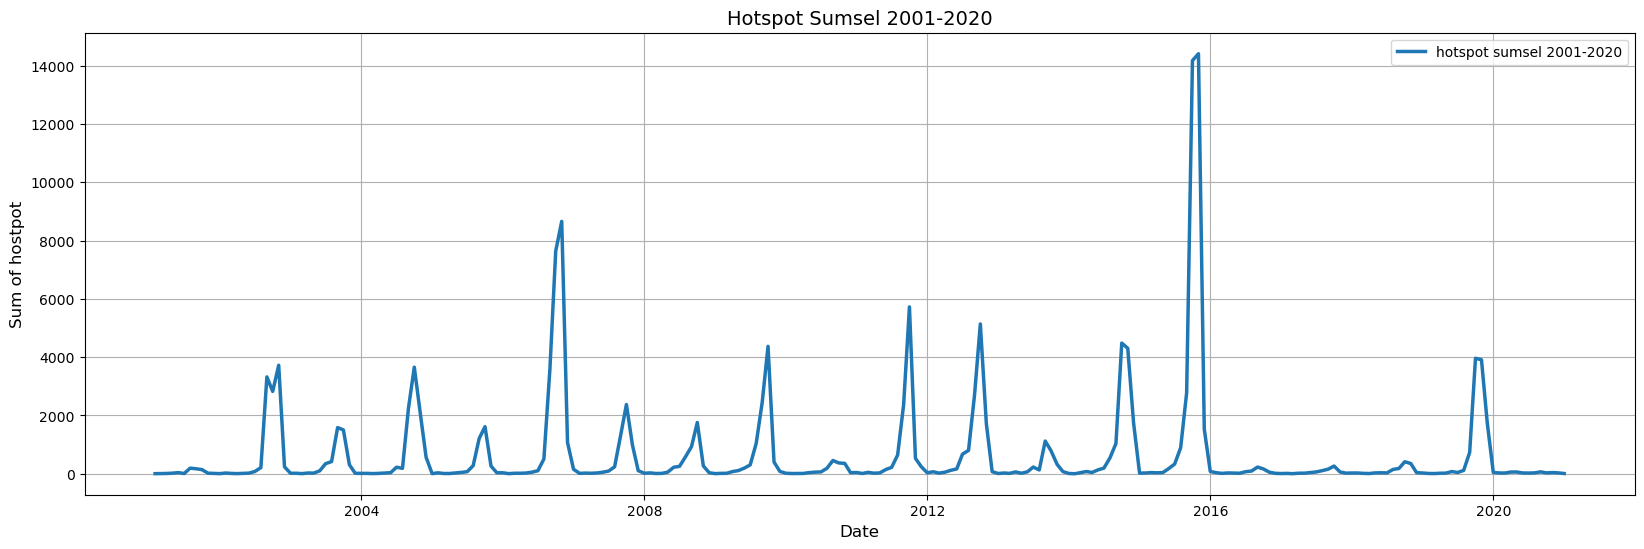

In [9]:
# make frame
fig, ax = plt.subplots(figsize = (20,6))

# make time series plot
ax.plot(dataset["tanggal"], dataset["hotspot_sumsel"], color="tab:blue", label="hotspot sumsel 2001-2020", linewidth=2.5)

# make are labels
ax.set_title("Hotspot Sumsel 2001-2020", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Sum of hostpot", fontsize=12)
ax.legend(loc='best')
ax.grid(True)

# show plot time series
plt.show()

- Analysis ACF and PACF

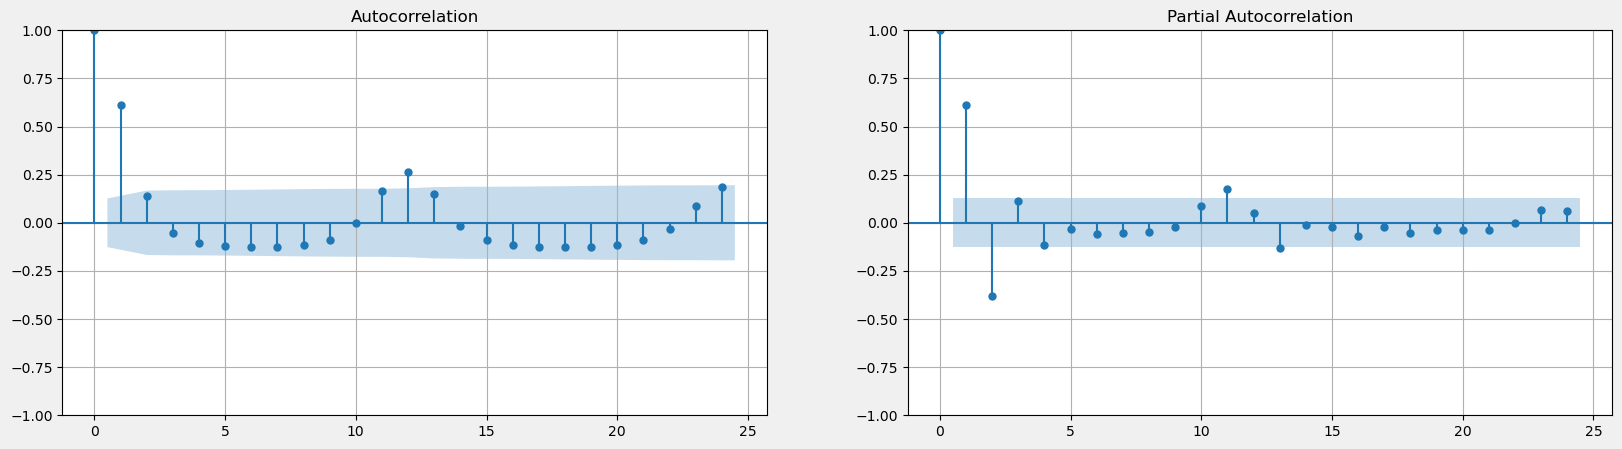

In [10]:
# make frame
fig, ax= plt.subplots(nrows=1, ncols=2, facecolor="#F0F0F0", figsize = (20,5))

# plot acf
plot_acf(dataset["hotspot_sumsel"], lags=24, ax=ax[0])
ax[0].grid(True)

# plot pacf
plot_pacf(dataset["hotspot_sumsel"],lags=24, ax=ax[1], method="yw")
ax[1].grid(True)

# show plot acf and pacf
plt.show()

### 4. Praproses Data

- 1. feature selection (studi kasus sumatera selatan)

In [11]:
# memilih area studi
df_sumsel = dataset[["hotspot_sumsel"]]

In [12]:
# ensure all data is float
df_sumsel = df_sumsel.values
df_sumsel = df_sumsel.astype('float64');

In [13]:
# show a dataset
np.round(df_sumsel[:5],4)

array([[ 3.],
       [ 5.],
       [10.],
       [20.],
       [39.]])

In [14]:
# view a dimension dataset
df_sumsel.shape

(240, 1)

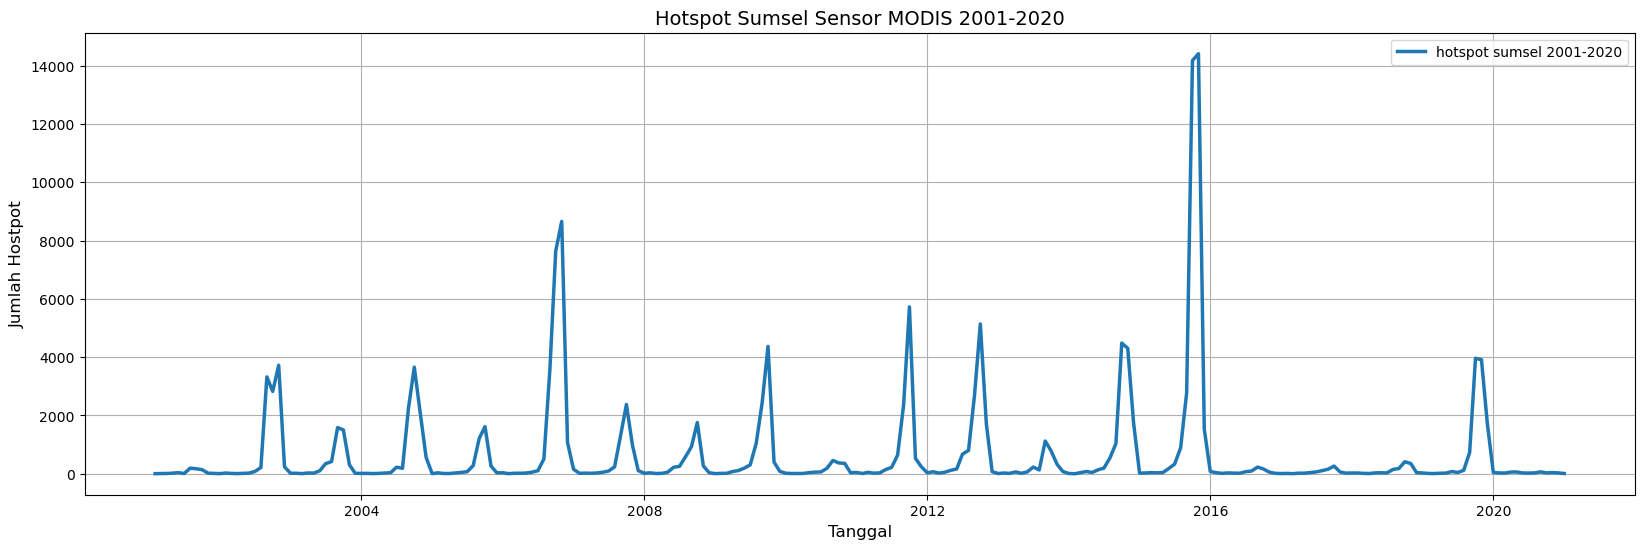

In [15]:
# membuat frame
fig, ax = plt.subplots(figsize = (20,6))

# membuat time series plot
ax.plot(dataset["tanggal"], df_sumsel, color="tab:blue", label="hotspot sumsel 2001-2020", linewidth=2.5)

# membuat label-label
ax.set_title("Hotspot Sumsel Sensor MODIS 2001-2020", fontsize=14)
ax.set_xlabel("Tanggal", fontsize=12)
ax.set_ylabel("Jumlah Hostpot", fontsize=12)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

- 2. Normalisasi Data

In [16]:
# normalize features
scaler = MinMaxScaler(feature_range=(-1,1))
df_sumsel = scaler.fit_transform(df_sumsel)

In [17]:
np.round(df_sumsel[:5],6)

array([[-0.999723],
       [-0.999445],
       [-0.998751],
       [-0.997364],
       [-0.994728]])

In [18]:
# view a dimension dataset after normalize
df_sumsel.shape

(240, 1)

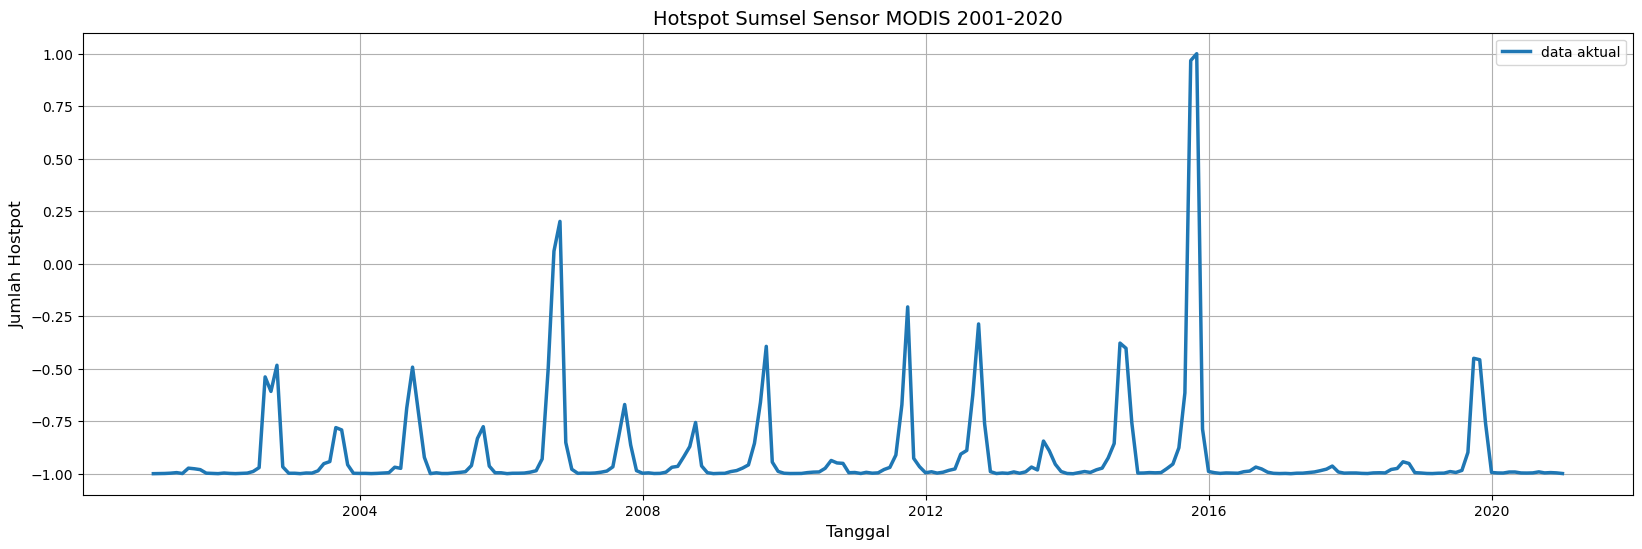

In [19]:
# membuat frame
fig, ax = plt.subplots(figsize = (20,6))

# membuat time series plot
ax.plot(dataset["tanggal"], df_sumsel, color="tab:blue", label="data aktual", linewidth=2.5)

# membuat label-label
ax.set_title("Hotspot Sumsel Sensor MODIS 2001-2020", fontsize=14)
ax.set_xlabel("Tanggal", fontsize=12)
ax.set_ylabel("Jumlah Hostpot", fontsize=12)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

- 3. set data train and data test

In [20]:
# set data train
train_size = int(len(df_sumsel) * 0.8)

In [21]:
# set loc data train
train = df_sumsel[0:train_size,:]

In [22]:
# show data train
np.round(train[:5],4)

array([[-0.9997],
       [-0.9994],
       [-0.9988],
       [-0.9974],
       [-0.9947]])

In [23]:
# view dimension of data train
train.shape

(192, 1)

In [24]:
# set data test
test_size = len(df_sumsel) - train_size

In [25]:
# set loc data test
test = df_sumsel[train_size:len(df_sumsel),:]

In [26]:
# show data test
np.round(test[:5],4)

array([[-0.9985],
       [-0.9997],
       [-0.9975],
       [-0.9974],
       [-0.9945]])

In [27]:
# view dimension of data test
test.shape

(48, 1)

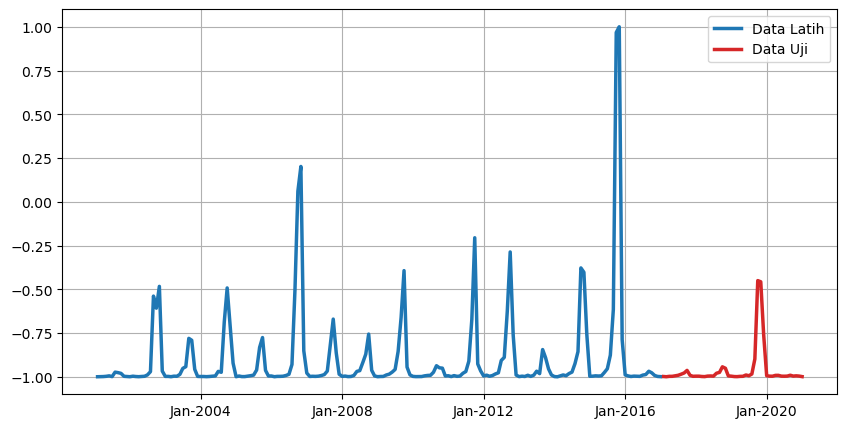

In [28]:
# make a frame
fig, ax = plt.subplots(figsize = (10,5))

# make a time series plot
ax.plot(dataset.iloc[0:train_size,0], train, color="tab:blue", label="Data Latih", linewidth=2.5)
ax.plot(dataset.iloc[train_size:len(dataset),0], test, color="tab:red", label="Data Uji", linewidth=2.5)

# make are labels
# ax.set_title("Hotspot Sumsel Sensor MODIS 2001-2020", fontsize=14)
# ax.set_xlabel("Years", fontsize=12)
# ax.set_ylabel("Sum of hotspot", fontsize=12)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.legend(loc="best")
ax.grid(True)

# show plot time series
plt.show()

### 5. Supervised Learning

In [29]:
# function for supervised learning
def create_dataset(dataset, look_back=1):
    
    # declare variable X and Y
    dataX = []
    dataY = []
    
    # for loop for create supervised learning
    for i in range(len(dataset)-look_back):
        
        # insert value X and Y 
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    
    # return value X and Y
    return np.array(dataX), np.array(dataY)

- process supervised learning, with look back t-1 into X=t and Y=t+1

In [30]:
# set look back -1
look_back = 1

In [31]:
# set supervised learning for data train
trainX, trainY = create_dataset(train, look_back)

In [32]:
# view a dimension dataset after supervised learning
print(trainX.shape, trainY.shape)

(191, 1) (191,)


In [33]:
# set supervised learning for data test
testX, testY = create_dataset(test, look_back)

In [34]:
# view a dimension dataset after supervised learning
print(testX.shape, testY.shape)

(47, 1) (47,)


- Check data train, for result supervised learning

In [35]:
temp_trainX = pd.DataFrame(trainX, columns=['x train'])
temp_trainY = pd.DataFrame(trainY, columns=['y train'])

In [36]:
hasil_train = pd.concat([temp_trainX, temp_trainY], axis=1)
hasil_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   x train  191 non-null    float64
 1   y train  191 non-null    float64
dtypes: float64(2)
memory usage: 3.1 KB


In [37]:
hasil_train.head()

,x train,y train
0,-0.999723,-0.999445
1,-0.999445,-0.998751
2,-0.998751,-0.997364
3,-0.997364,-0.994728
4,-0.994728,-0.999029


- Check data test, for result supervised learning

In [38]:
temp_testX = pd.DataFrame(testX, columns=['x test'])
temp_testY = pd.DataFrame(testY, columns=['y test'])

In [39]:
hasil_test = pd.concat([temp_testX, temp_testY], axis=1)
hasil_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x test  47 non-null     float64
 1   y test  47 non-null     float64
dtypes: float64(2)
memory usage: 884.0 bytes


In [40]:
hasil_test.head()

,x test,y test
0,-0.998474,-0.999723
1,-0.999723,-0.997503
2,-0.997503,-0.997364
3,-0.997364,-0.994450
4,-0.994450,-0.991537


- reshape input for samples, time steps, features

In [41]:
# reshape data train
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

In [42]:
print(trainX.shape, trainY.shape)

(191, 1, 1) (191,)


In [43]:
# reshape data test
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [44]:
print(testX.shape, testY.shape)

(47, 1, 1) (47,)


### 6. Modeling LSTM-RNN

In [45]:
# Design network
model = Sequential()

# First LSTM layer with Dropout regularisation
model.add(
    LSTM(
        units=10,
        activation="selu",
        input_shape=(trainX.shape[1], 1)
    )
)
model.add(Dropout(0.15))

# The output layer
model.add(Dense(1))

# Compiling model the LSTM-RNN
model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)

In [46]:
# fit network
history = model.fit(trainX, trainY, epochs=2000, batch_size=8,
                    validation_data=(testX, testY),
                    verbose=0, shuffle=False)

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


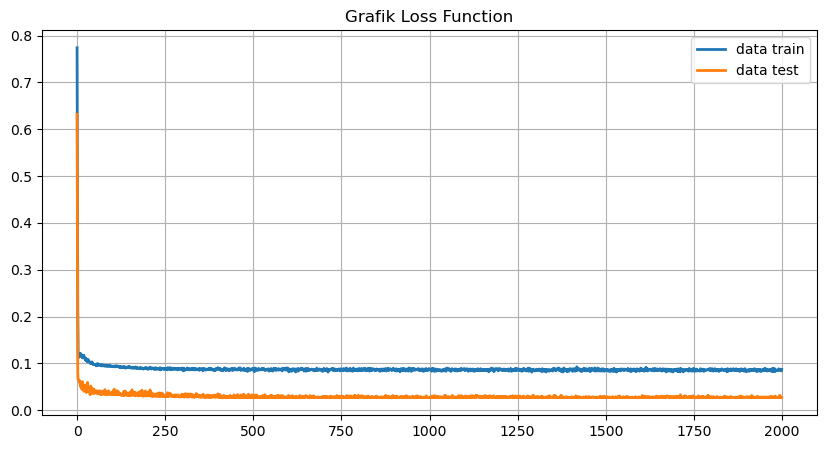

In [48]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(history.history['loss'], color="tab:blue", label="data train", linewidth=2)
ax.plot(history.history['val_loss'], color="tab:orange", label="data test", linewidth=2)

# membuat label-label
ax.set_title("Grafik Loss Function")
ax.legend(loc="best")
ax.grid(True)

# menampilkan plot
plt.show()

In [49]:
# 5. make predictions
predictions = model.predict(testX, verbose=0)
print(predictions[:, 0])

[-0.99379414 -0.99420315 -0.9934761  -0.9934307  -0.99247706 -0.99097973
 -0.9865711  -0.98143035 -0.97089267 -0.9910588  -0.9933852  -0.9931581
 -0.9931581  -0.99374866 -0.9939759  -0.9930219  -0.9927949  -0.9930673
 -0.9825352  -0.97902715 -0.95660096 -0.96229285 -0.99261326 -0.9931581
 -0.993885   -0.99402136 -0.9935215  -0.9933852  -0.9898204  -0.9923409
 -0.9857616  -0.92664206 -0.7056769  -0.70811117 -0.84305066 -0.9923409
 -0.99311274 -0.99324894 -0.9912171  -0.9911379  -0.99311274 -0.99324894
 -0.9930219  -0.99074244 -0.9930219  -0.9925225  -0.9929765 ]


### 7. Evaluasi Model LSTM-RNN
- https://www.datatechnotes.com/2019/02/regression-model-accuracy-mae-mse-rmse.html
- https://lms.onnocenter.or.id/wiki/index.php/Orange:_Metric_Evaluation_Model#Mean_Squared_Error_.28MSE.29
- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [50]:
scores = model.evaluate(trainX, trainY)
scores

6/6 [==============================] - 0s 3ms/step - loss: 0.0827 - mean_absolute_error: 0.0827 - mean_squared_error: 0.0487 - root_mean_squared_error: 0.2207


[0.0826769694685936,
 0.0826769694685936,
 0.04869643971323967,
 0.22067269682884216]

In [51]:
scores = model.evaluate(testX, testY)
scores

2/2 [==============================] - 0s 16ms/step - loss: 0.0274 - mean_absolute_error: 0.0274 - mean_squared_error: 0.0069 - root_mean_squared_error: 0.0832


[0.027357254177331924,
 0.027357254177331924,
 0.00692685367539525,
 0.0832277238368988]

- MAE (Mean Absolute Error)

In [52]:
mae = mean_absolute_error(testY, predictions)
print('Test MAE : %.4f' % mae)

Test MAE : 0.0274


- MSE (Mean Squared Error)

In [53]:
mse = mean_squared_error(testY, predictions)
print('Test MSE: %.4f' % mse)

Test MSE: 0.0069


- RMSE (Root Mean Squared Error)

In [54]:
# calculate RMSE
rmse = sqrt(mse)
print('Test RMSE: %.4f' % rmse)

Test RMSE: 0.0832


- MAPE (Mean Absolute Percentage Error)

In [55]:
mape = mean_absolute_percentage_error(testY, predictions)
print('Test MAPE: %.4f' % mape)

Test MAPE: 0.0467


- Korelasi dan Signifikansi

In [56]:
hasil = np.stack((testY.reshape(-1), predictions.reshape(-1)), axis=1)
hasil = pd.DataFrame(hasil, columns = ['data_aktual','prediksi'])
hasil.head()

,data_aktual,prediksi
0,-0.999723,-0.993794
1,-0.997503,-0.994203
2,-0.997364,-0.993476
3,-0.994450,-0.993431
4,-0.991537,-0.992477


In [57]:
import scipy.stats as sc
r, p = sc.pearsonr(hasil["data_aktual"], hasil["prediksi"])
print("korelasi data akual dengan hasil prediksi" +" {:.4f} ".format(r)+ "dengan signifikansi" +" {:.4f} ".format(p))

korelasi data akual dengan hasil prediksi 0.7073 dengan signifikansi 0.0000 


- Waktu komputasi

In [58]:
# Set akhir waktu komputasi 
end = time.time()

In [59]:
# Proses menghitung waktu komputasi
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)

In [60]:
# Hasil waktu komputasi
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:03:15.78


### 8. Visualisasi Data LSTM-RNN

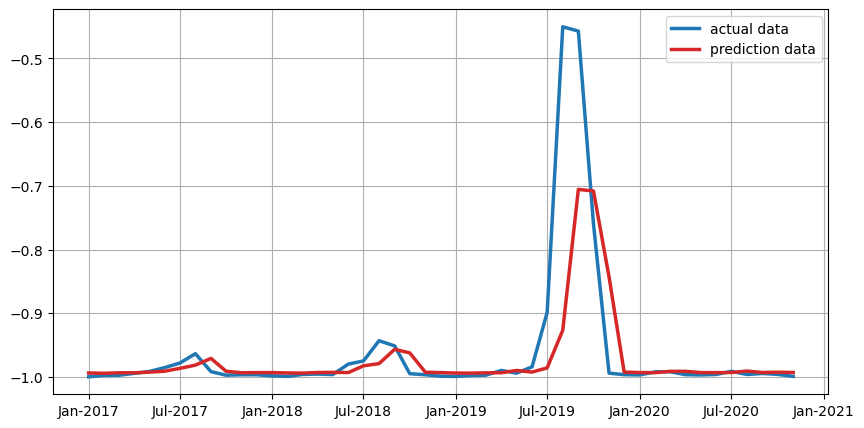

In [61]:
# generate urutan data sesuai panjang datanya
x = pd.date_range(start="2017-01-01", periods=len(testY), freq='MS')

# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(x, testY, color="tab:blue", label="actual data", linewidth=2.5)
ax.plot(x, predictions, color="tab:red", label="prediction data", linewidth=2.5)

# membuat label-label
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.legend(loc="best")
ax.grid(True)

# menampilkan plot
plt.show()

In [62]:
# inverse value test predictions
testPredictions = scaler.inverse_transform(predictions)
testActual = scaler.inverse_transform(testY.reshape(-1, 1))

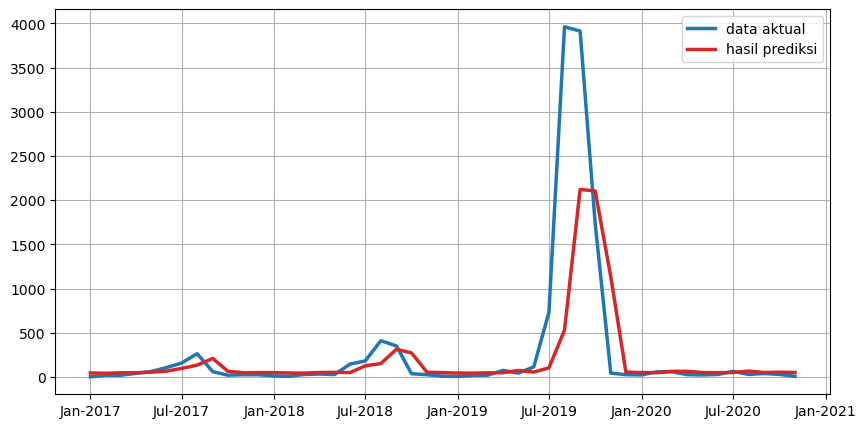

In [63]:
# generate urutan data sesuai panjang datanya
x = pd.date_range(start="2017-01-01", periods=len(testY), freq='MS')

# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(x, testActual, color="tab:blue", label="data aktual", linewidth=2.5)
ax.plot(x, testPredictions, color="tab:red", label="hasil prediksi", linewidth=2.5)

# membuat label-label
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.legend(loc="best")
ax.grid(True)

# menampilkan plot
plt.show()

In [64]:
#  shift test predictions for plotting
testPredictionsPlot = np.empty_like(df_sumsel)
testPredictionsPlot[:, :] = np.nan
testPredictionsPlot[(len(dataset) - testPredictions.shape[0]):len(dataset), :] = testPredictions

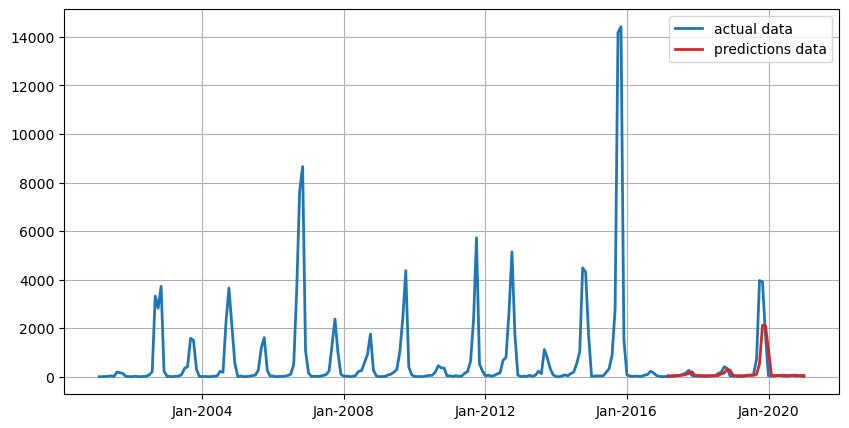

In [65]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(dataset["tanggal"], scaler.inverse_transform(df_sumsel), color="tab:blue", label="actual data", linewidth=2)
ax.plot(dataset["tanggal"], testPredictionsPlot, color="tab:red", label="predictions data", linewidth=2)

# membuat label-label
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.legend(loc="best")
ax.grid(True)

# menampilkan plot
plt.show()

In [66]:
pd.DataFrame(np.round(testActual,0))

,0
0,3.0
1,19.0
2,20.0
3,41.0
4,62.0
5,107.0
6,158.0
7,264.0
8,61.0
9,21.0
